# Housing Prices in Major Cities on the West Coast

This notebook compares housing prices in major cities on the West Coast using data from Zillow. 

### Next Steps
I would appreciate if you could do the following as quickly as possible. You should be able to reuse code in this notebook.
1. Get the unique name / id that the data uses for San Jose, CA
2. Plot Rental prices and Home prices for San Jose, CA
3. Coorelate changes in San Jose Rental and Home prices to those in the five other major West Coast cities.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
# import data, starting with just the city data
df_data_dict = pd.read_csv('data/data_dictionary.csv', encoding = 'latin1')
df_city_prices = pd.read_csv('data/city_time_series.csv')
df_city_ids = pd.read_csv('data/cities_crosswalk.csv')

In [3]:
print('Data Dict shape %s x %s' % (df_data_dict.shape[0], df_data_dict.shape[1]))
print('City Time Series shape %s x %s' % (df_city_prices.shape[0], df_city_prices.shape[1]))
print('City Index shape %s x %s' % (df_city_ids.shape[0], df_city_ids.shape[1]))

Data Dict shape 30 x 2
City Time Series shape 3762566 x 81
City Index shape 25341 x 4


There is a lot of data in the City table. Let's see how many cities there are.

In [4]:
len(df_city_prices['RegionName'].value_counts())

16636

That are over 16,000 cities in the dataset. Let's see how many are on the west coast.

In [5]:
# get city ids for cities in western states
western_states = ['CA', 'OR', 'WA']
df_west_city_ids = df_city_ids[df_city_ids['State'].isin(western_states)]
western_ids = df_west_city_ids['Unique_City_ID']

# find how many are in our dataset
len(df_city_prices[df_city_prices['RegionName'].isin(western_ids)]['RegionName'].value_counts())

1335

That still leaves us with over 1000 cities. We may want to come back to those, but for now, let's look at just the major West Coast cities.

There are 1335 cities in CA, OR, and WA. That is more than we want to analyze, at least for now. Let's start with a hand-picked list of five major cities in the west.

In [6]:
def get_city_id(city, state):
    
    # get the unique id for a particular city
    matches = df_city_ids[(df_city_ids['City'] == city) & (df_city_ids['State'] == state)]
    
    # return the first match
    if matches.shape[0] > 0:
        return matches.iloc[0]['Unique_City_ID']
    else:
        return None

In [7]:
# get the ids for certain cities
west_coast_cities = [
    ['Seattle', 'WA'],
    ['Portland', 'OR'],
    ['San Francisco', 'CA'],
    ['Los Angeles', 'CA'],
    ['San Diego', 'CA']
]

west_coast_city_ids = []

for c in west_coast_cities:
    cid = get_city_id(c[0], c[1])
    if cid:
        west_coast_city_ids.append(cid)
        
west_coast_city_ids

['seattlekingwa',
 'portlandmultnomahor',
 'san_franciscosan_franciscoca',
 'los_angeleslos_angelesca',
 'san_diegosan_diegoca']

Now we can reduce our dataset to only rows for the cities we care about. 

While we are at it, let's convert the Date column to an actual Date object rather than just a string.

In [8]:
df_west_coast_prices = df_city_prices[df_city_prices['RegionName'].isin(west_coast_city_ids)]
df_west_coast_prices.groupby('RegionName')['RegionName'].count()

RegionName
los_angeleslos_angelesca        261
portlandmultnomahor             261
san_diegosan_diegoca            261
san_franciscosan_franciscoca    261
seattlekingwa                   261
Name: RegionName, dtype: int64

In [9]:
def convert_to_datetime(series):
    return pd.to_datetime(series, infer_datetime_format=True)

In [10]:
df_west_coast_prices['Date'] = pd.to_datetime(df_west_coast_prices['Date'])

/Users/adam/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


Now let's see what kind of data we can use for the comparison.

In [11]:
print("%s variables in our dataset" % df_city_prices.shape[0])
df_city_prices.columns

3762566 variables in our dataset


Index(['Date', 'RegionName', 'InventorySeasonallyAdjusted_AllHomes',
       'InventoryRaw_AllHomes', 'MedianListingPricePerSqft_1Bedroom',
       'MedianListingPricePerSqft_2Bedroom',
       'MedianListingPricePerSqft_3Bedroom',
       'MedianListingPricePerSqft_4Bedroom',
       'MedianListingPricePerSqft_5BedroomOrMore',
       'MedianListingPricePerSqft_AllHomes',
       'MedianListingPricePerSqft_CondoCoop',
       'MedianListingPricePerSqft_DuplexTriplex',
       'MedianListingPricePerSqft_SingleFamilyResidence',
       'MedianListingPrice_1Bedroom', 'MedianListingPrice_2Bedroom',
       'MedianListingPrice_3Bedroom', 'MedianListingPrice_4Bedroom',
       'MedianListingPrice_5BedroomOrMore', 'MedianListingPrice_AllHomes',
       'MedianListingPrice_CondoCoop', 'MedianListingPrice_DuplexTriplex',
       'MedianListingPrice_SingleFamilyResidence',
       'MedianPctOfPriceReduction_AllHomes',
       'MedianPctOfPriceReduction_CondoCoop',
       'MedianPctOfPriceReduction_SingleFamily

In [12]:
print("%s variables with a definition" % df_data_dict.shape[0])
df_data_dict.head()

30 variables with a definition


,Variable,Definition
0,AgeOfInventory,"Each Wednesday, age of inventory is calculated..."
1,DaysOnZillow,The median days on market of homes sold within...
2,HomesSoldAsForeclosuresRatio,"The number of homes (per 10,000 homes) that we..."
3,InventorySeasonallyAdjusted,A seasonally adjusted measure of the median of...
4,InventoryRaw,Median of weekly snapshot of for-sale homes wi...


That is a lot of variables, and we don't seem to have a defenition for each of them (81 variables, but only 30 definitions). Instead of looking through the data dictionary by hand, let's make it easier to find the definition of different variables.

In [13]:
def get_variable_def(variable):
    matched_vars = df_data_dict[df_data_dict['Variable'] == variable]
    if matched_vars.shape[0] > 0:
        return matched_vars.iloc[0]['Definition']
    else:
        return "No Definition Found"

In [14]:
get_variable_def('ZHVI')

'A smoothed seasonally adjusted measure of the median estimated home value across a given region and housing type'

In [15]:
get_variable_def('ZRI')

'A smoothed seasonally adjusted measure of the median estimated market rate rent across a given region and housing type'

Let's start by looking at Home Values (ZHVI) and Rental Prices (ZRI) in the five major cities. Note that the vairable names in the dataframe are actually ZHVI_AllHomes and ZRI_AllHomes.

In [16]:
def plot_metric(city, state, metric, df):
    city_id = get_city_id(city, state)
    df_c = df[df['RegionName'] == city_id]
    
    if df_c.shape[0] == 0:
        print('No data for %s, %s' % (city, state))
        
    else:
        plt.xlabel('Date')
        plt.ylabel(metric)
        plt.title(city + ' - ' + metric)
        plt.plot(df_c['Date'], df_c[metric])

### Rental Prices over Time

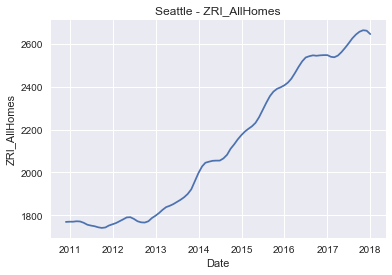

In [17]:
plot_metric('Seattle', 'WA', 'ZRI_AllHomes', df_west_coast_prices)

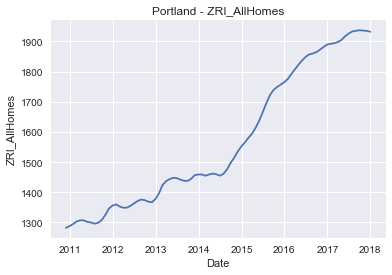

In [18]:
plot_metric('Portland', 'OR', 'ZRI_AllHomes', df_west_coast_prices)

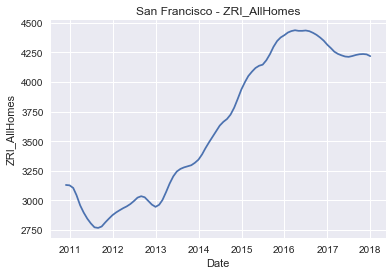

In [19]:
plot_metric('San Francisco', 'CA', 'ZRI_AllHomes', df_west_coast_prices)

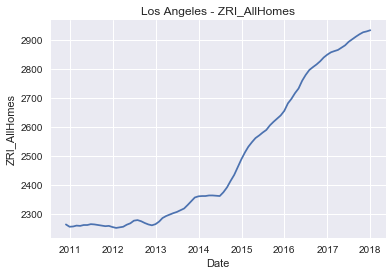

In [20]:
plot_metric('Los Angeles', 'CA', 'ZRI_AllHomes', df_west_coast_prices)

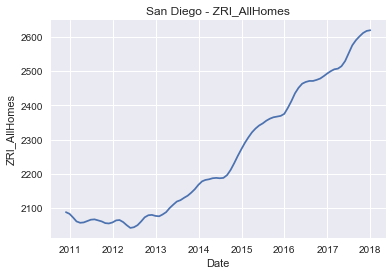

In [21]:
plot_metric('San Diego', 'CA', 'ZRI_AllHomes', df_west_coast_prices)

### Home Prices over Time

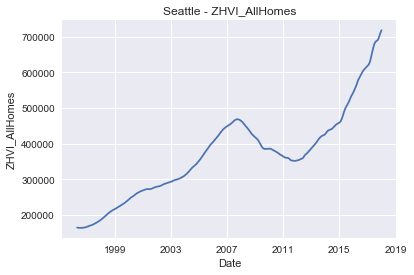

In [22]:
plot_metric('Seattle', 'WA', 'ZHVI_AllHomes', df_west_coast_prices)

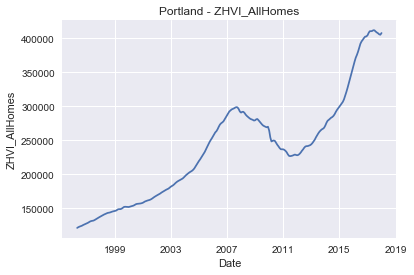

In [23]:
plot_metric('Portland', 'OR', 'ZHVI_AllHomes', df_west_coast_prices)

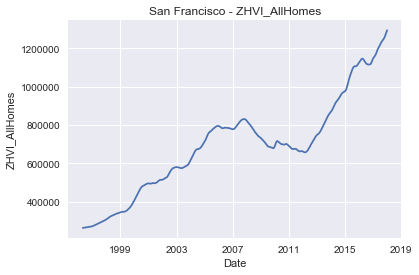

In [24]:
plot_metric('San Francisco', 'CA', 'ZHVI_AllHomes', df_west_coast_prices)

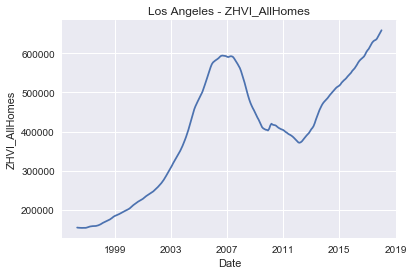

In [25]:
plot_metric('Los Angeles', 'CA', 'ZHVI_AllHomes', df_west_coast_prices)

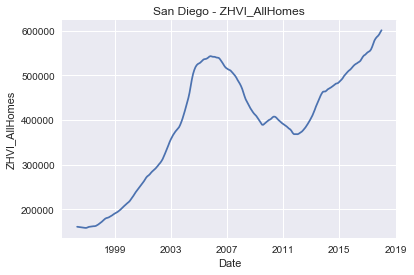

In [26]:
plot_metric('San Diego', 'CA', 'ZHVI_AllHomes', df_west_coast_prices)

### Get Price Changes

Now let's see if we can find a coorelation between price changes. Do certain cities act like certain other cities when it comes to how their home and rental prices rise and fall?

Let's create two new dataframes, one for Rental prices, and one for Home prices in our five cities.

In [27]:
df_west_cities_home = df_west_coast_prices[df_west_coast_prices['ZHVI_AllHomes'].isnull() == False]
df_west_cities_home.head()

,Date,RegionName,InventorySeasonallyAdjusted_AllHomes,InventoryRaw_AllHomes,MedianListingPricePerSqft_1Bedroom,MedianListingPricePerSqft_2Bedroom,MedianListingPricePerSqft_3Bedroom,MedianListingPricePerSqft_4Bedroom,MedianListingPricePerSqft_5BedroomOrMore,MedianListingPricePerSqft_AllHomes,...,ZHVI_BottomTier,ZHVI_CondoCoop,ZHVI_MiddleTier,ZHVI_SingleFamilyResidence,ZHVI_TopTier,ZRI_AllHomes,ZRI_AllHomesPlusMultifamily,ZriPerSqft_AllHomes,Zri_MultiFamilyResidenceRental,Zri_SingleFamilyResidenceRental
5551,1996-04-30,los_angeleslos_angelesca,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,112100.0,132500.0,155000.0,161900.0,306900.0,NaN,NaN,NaN,NaN,NaN
7899,1996-04-30,portlandmultnomahor,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,84900.0,NaN,121100.0,117600.0,182200.0,NaN,NaN,NaN,NaN,NaN
8647,1996-04-30,san_diegosan_diegoca,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,103900.0,123900.0,161100.0,181100.0,268400.0,NaN,NaN,NaN,NaN,NaN
8650,1996-04-30,san_franciscosan_franciscoca,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,191800.0,264600.0,262500.0,261300.0,364900.0,NaN,NaN,NaN,NaN,NaN
8836,1996-04-30,seattlekingwa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,115100.0,135100.0,164400.0,173400.0,249500.0,NaN,NaN,NaN,NaN,NaN


In [28]:
df_west_cities_rental = df_west_coast_prices[df_west_coast_prices['ZRI_AllHomes'].isnull() == False]
df_west_cities_rental.head()

,Date,RegionName,InventorySeasonallyAdjusted_AllHomes,InventoryRaw_AllHomes,MedianListingPricePerSqft_1Bedroom,MedianListingPricePerSqft_2Bedroom,MedianListingPricePerSqft_3Bedroom,MedianListingPricePerSqft_4Bedroom,MedianListingPricePerSqft_5BedroomOrMore,MedianListingPricePerSqft_AllHomes,...,ZHVI_BottomTier,ZHVI_CondoCoop,ZHVI_MiddleTier,ZHVI_SingleFamilyResidence,ZHVI_TopTier,ZRI_AllHomes,ZRI_AllHomesPlusMultifamily,ZriPerSqft_AllHomes,Zri_MultiFamilyResidenceRental,Zri_SingleFamilyResidenceRental
2357025,2010-11-30,los_angeleslos_angelesca,11487.0,11733.0,NaN,NaN,NaN,NaN,NaN,NaN,...,258000.0,350300.0,405100.0,424100.0,794300.0,2263.0,2186.0,1.580,1976.0,2306.0
2360315,2010-11-30,portlandmultnomahor,3521.0,3574.0,256.726037,178.751823,144.367418,149.439462,145.148029,164.495362,...,161300.0,NaN,236600.0,250500.0,386800.0,1282.0,1282.0,1.020,1342.0,1281.0
2361368,2010-11-30,san_diegosan_diegoca,6357.0,6498.0,NaN,NaN,NaN,267.063542,NaN,NaN,...,236300.0,299100.0,393100.0,443000.0,671400.0,2088.0,2071.0,1.494,1788.0,2234.0
2361372,2010-11-30,san_franciscosan_franciscoca,NaN,NaN,640.918803,NaN,NaN,NaN,NaN,NaN,...,504600.0,666500.0,696500.0,709600.0,988100.0,3130.0,3189.0,2.504,3192.0,3192.0
2361619,2010-11-30,seattlekingwa,3377.0,3464.0,358.539765,309.846651,250.000000,230.259366,206.552215,266.797130,...,249300.0,281000.0,366700.0,402700.0,583600.0,1769.0,1748.0,1.264,1478.0,1861.0


Now we can calculate the % change in Rental and Housing prices over time. Both will be how much prices change in a month. We only have rental data from 2010, but we have house price data  back to 1996.

In [29]:
def get_pct_change(city, state, variable, df):
    city_id = get_city_id(city, state)
    df_c = df[df['RegionName'] == city_id]
    change = df_c[variable].pct_change()
    df_change = pd.concat([df_c['Date'], change], axis = 1)
    df_change.columns = ['Date', city]
    return df_change

In [30]:
seattle_home_change = get_pct_change('Seattle', 'WA', 'ZHVI_AllHomes', df_west_cities_home)
portland_home_change = get_pct_change('Portland', 'OR', 'ZHVI_AllHomes', df_west_cities_home)
sf_home_change = get_pct_change('San Francisco', 'CA', 'ZHVI_AllHomes', df_west_cities_home)
la_home_change = get_pct_change('Los Angeles', 'CA', 'ZHVI_AllHomes', df_west_cities_home)
sd_home_change = get_pct_change('San Diego', 'CA', 'ZHVI_AllHomes', df_west_cities_home)

df_home_change = pd.merge(pd.DataFrame(seattle_home_change), portland_home_change, on = 'Date', how = 'left')
df_home_change = df_home_change.merge(sf_home_change, on='Date')
df_home_change = df_home_change.merge(la_home_change, on='Date')
df_home_change = df_home_change.merge(sd_home_change, on='Date')

In [31]:
df_home_change.head()

,Date,Seattle,Portland,San Francisco,Los Angeles,San Diego
0,1996-04-30,NaN,NaN,NaN,NaN,NaN
1,1996-05-31,-0.003041,0.009083,0.003810,-0.002581,-0.002483
2,1996-06-30,-0.001830,0.006547,0.002277,-0.001294,-0.001867
3,1996-07-31,-0.001222,0.004878,0.003408,-0.001295,-0.001870
4,1996-08-31,0.001224,0.005663,0.004906,-0.000649,-0.003123


In [32]:
seattle_rental_change = get_pct_change('Seattle', 'WA', 'ZRI_AllHomes', df_west_cities_rental)
portland_rental_change = get_pct_change('Portland', 'OR', 'ZRI_AllHomes', df_west_cities_rental)
sf_rental_change = get_pct_change('San Francisco', 'CA', 'ZRI_AllHomes', df_west_cities_rental)
la_rental_change = get_pct_change('Los Angeles', 'CA', 'ZRI_AllHomes', df_west_cities_rental)
sd_rental_change = get_pct_change('San Diego', 'CA', 'ZRI_AllHomes', df_west_cities_rental)

df_rental_change = pd.merge(pd.DataFrame(seattle_rental_change), portland_rental_change, on = 'Date', how = 'left')
df_rental_change = df_rental_change.merge(sf_rental_change, on='Date')
df_rental_change = df_rental_change.merge(la_rental_change, on='Date')
df_rental_change = df_rental_change.merge(sd_rental_change, on='Date')

In [33]:
df_rental_change.head()

,Date,Seattle,Portland,San Francisco,Los Angeles,San Diego
0,2010-11-30,NaN,NaN,NaN,NaN,NaN
1,2010-12-31,0.000565,0.004680,-0.000958,-0.003535,-0.002395
2,2011-01-31,0.000000,0.005435,-0.007035,0.000443,-0.005281
3,2011-02-28,0.001130,0.006178,-0.019646,0.001330,-0.005309
4,2011-03-31,-0.000564,0.003070,-0.028252,-0.000443,-0.001941


### Coorelate price changes

Now let's see which cities had a strong coorelation in housing price rise and fall.

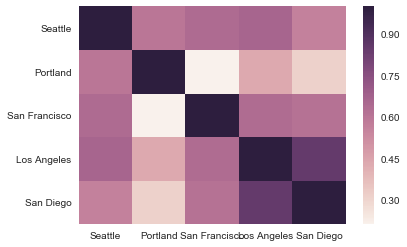

In [34]:
home_corr = df_home_change.corr()
sns.heatmap(home_corr)

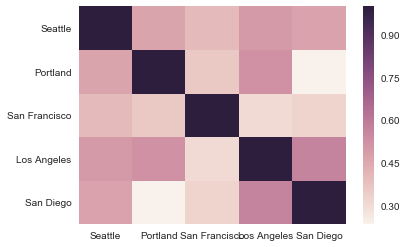

In [35]:
rental_corr = df_rental_change.corr()
sns.heatmap(rental_corr)

Overall it looks like Home Prices are much more coorelated than Rental Prices. Unsurprisingly, San Diego and Los Angeles have very similar markets, but surprisingly, Seattle and Portland do not.

### Next Steps
I would appreciate if you could do the following as quickly as possible:
1. Get the unique name / id that the data uses for San Jose, CA
2. Plot Rental prices and Home prices for San Jose, CA
3. Coorelate changes in San Jose Rental and Home prices with those in the five other major West Coast cities.